# Вспомогательный код

**Для выполнения задания рекомендуется использовать среду с аппаратным ускорителем GPU:**

In [26]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Блок кода для визуализации процесса обучения модели:

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import clear_output


class ProgressPlotter:
    def __init__(self) -> None:
        self._history_dict = defaultdict(list)

    def add_scalar(self, tag: str, value) -> None:
        self._history_dict[tag].append(value)

    def display_keys(self, ax, tags):
        if isinstance(tags, str):
            tags = [tags]
        history_len = 0
        ax.grid()
        for key in tags:
            ax.plot(self._history_dict[key], marker="X", label=key)
            history_len = max(history_len, len(self.history_dict[key]))
        if len(tags) > 1:
            ax.legend(loc="lower left")
        else:
            ax.set_ylabel(key)
        ax.set_xlabel("epoch")
        ax.set_xticks(np.arange(history_len))
        ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
        clear_output()
        n_groups = len(groups)
        fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3 * n_groups))
        if n_groups == 1:
            ax = [ax]
        for i, keys in enumerate(groups):
            self.display_keys(ax[i], keys)
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Чтобы результаты экспериментов воспроизводились, зафиксируем случайные состояния:

In [20]:
import random


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

# Задание 1. Создание полносвязной сети

1. Создайте двух-трехслойную* полносвязную нейронную сеть средствами PyTorch.
2. Дополните недостающий код для обучения.
3. Обучите нейросеть на CIFAR-10.
4. Посмотрите график зависимости loss и accuracy от эпохи в процессе обучения.

Для создания полносвязных слоев используйте класс [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear).

*Рекомендуется использовать скрытый слой со 128 нейронами.

Установка и импорт необходимых библиотек:

In [4]:
!pip install -q torchmetrics

In [5]:
import torchvision
import torchmetrics
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split

Загрузим датасет с помощью средств PyTorch.

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_val_data = CIFAR10(root="./CIFAR10", train=True, download=True, transform=transform)
test_data = CIFAR10(root="./CIFAR10", train=False, download=True, transform=transform)

train_data, val_data = random_split(train_val_data, lengths=[40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


Обучающая выборка CIFAR-10 содержит 50&nbsp;000 изображений. При помощи функции [`random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) из модуля `torch.utils.data` мы взяли 40&nbsp;000 для обучения и 10&nbsp;000 для валидации.

Также обратите внимание, что сумма значений в параметре `lengths` функции `random_split` должна в точности равняться количеству элементов в датасете, который она разделяет.

Объекты `train_data`, `val_data` являются продуктами разбиения объекта `train_val_data`. Указатель на этот объект хранится в атрибуте `.dataset` этих объектов:

In [7]:
(train_data.dataset is train_val_data) and (train_data.dataset is val_data.dataset)

True

Опишите структуру сети: полносвязные слои + [функции активации](https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity) на ваш выбор.

In [8]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 140)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(140, 10)
        self.tanh = nn.Tanh()
        self.logit = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.tanh(x)
        # x = self.fc3(x)
        logits = self.logit(x)
        return logits

**Блок обучения.**

Обратите внимание на то, что в PyTorch моделях не используется метод `fit`, как в Sklearn. Код, отвечающий за обучение, пишется отдельно.

Определим `batch_size` и создадим два DataLoader-а для обучающей и валидационной выборок:

In [9]:
batch_size = 256

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

Функцию для подсчёта точности возьмем из библиотеки [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html):

In [10]:
score_function = torchmetrics.Accuracy(task="multiclass", num_classes=10)

**Цикл обучения и валидации.**

Определим функции `train_loop` и `val_loop`. Допишите недостающий код. Пользуйтесь материалом лекции.


In [22]:
def train_loop(dataloader, model, criterion, optimizer, score_function, device):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        
        pred = model(imgs.to(device))
        loss = criterion(pred, labels.to(device))

        # Optimization
        # Nullify gradients, do a backward and do an optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # End of your code

        train_loss += loss.detach().item()

        # accumulating predictions and true labels to calculate score function
        score_function.update(pred.cpu(), labels)

    train_loss /= num_batches

    train_score = score_function.compute().item()
    score_function.reset()

    return train_loss, train_score

In [23]:
def val_loop(dataloader, model, criterion, score_function, device):
    num_batches = len(dataloader)

    val_loss = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred =  model(imgs.to(device))
            loss =  criterion(pred, labels.to(device))

            val_loss += loss.item()

            # accumulating predictions and true labels to calculate score function
            score_function.update(pred.cpu(), labels)

    val_loss /= num_batches

    val_score = score_function.compute().item()
    score_function.reset()

    return val_loss, val_score

Дополните функцию `train` вызовом `train_loop` и `val_loop` внутри цикла по эпохам:

In [24]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
):

    pp = ProgressPlotter()
    for i in range(num_epochs):

        # properly call train_loop and val_loop
        train_loss, train_score = train_loop(train_loader, model, criterion, optimizer, score_function, device)


        val_loss, val_score = val_loop(val_loader, model, criterion, score_function, device)

        # logging
        pp.add_scalar("loss_train", train_loss)
        pp.add_scalar("score_train", train_score)

        pp.add_scalar("loss_val", val_loss)
        pp.add_scalar("score_val", val_score)

        pp.display([["loss_train", "loss_val"], ["score_train", "score_val"]])
    return pp

Создание экземпляра модели, определение оптимизатора, функции потерь, и собственно запуск обучения.

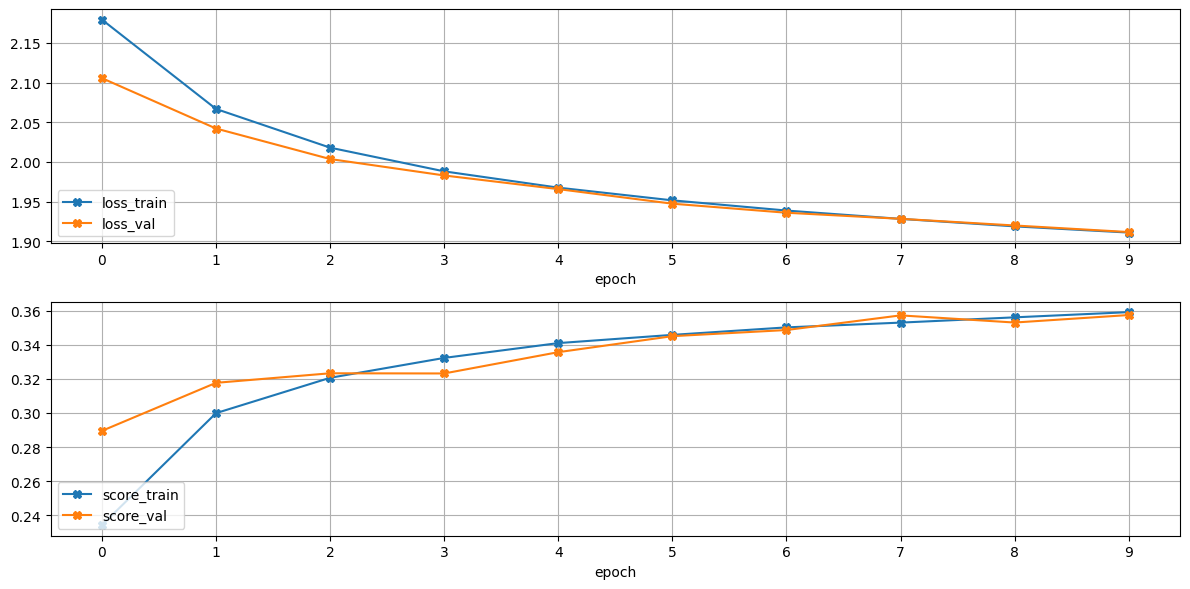

In [14]:
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
)

Функция `train` возвращает объект `ProgressPlotter`, который имеет атрибут `.history_dict` — словарь, в котором хранится история обучения модели: значение функции потерь и точности на обучающих и валидационных данных по эпохам.

По ключу `score_val` можно извлечь из словаря значения точности на валидационных данных по эпохам и вывести итоговую точность модели, достигнутую на последней эпохе (обратимся к последнему элементу в списке по индексу `-1`).

In [15]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.36


## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_1_task_ex05.png" width="800">

# Задание 2. Нормализация данных

Стандартизируйте данные и обучите модель на стандартизованных данных.

* Подсчитайте среднее значение и стандартное отклонение по обучающей выборке для каждого из 3-х цветовых каналов с помощью встроенных в PyTorch или NumPy функций.
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`[🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)).
* Оцените влияние нормировки данных на точность обучения (сравните результаты обучения на сырых данных в задании №1 и на стандартизованных).

Посмотрим на размерность тензора с обучающими данными:

In [16]:
raw_train_data = train_data.dataset.data[train_data.indices]

print(type(raw_train_data))
print(raw_train_data.shape)

<class 'numpy.ndarray'>
(40000, 32, 32, 3)


Вычислите средние и стандартные отклонения **по каждому из трех цветовых каналов** для обучающих данных.

Каждый канал изображения стандартизуется независимо. Поэтому каждый из объектов `cifar10_mean` и `cifar10_std` должен представлять из себя последовательность (`list` / `np.ndarray` / `torch.Tensor`) длиной в количество каналов.

Также не забудьте, что `Normalize` будет применяться после `ToTensor`, и поэтому средние и стандартные отклонения должны быть отмасштабированы в $[0,1]$.

In [17]:
cifar10_mean = raw_train_data.mean(axis=(0,1,2)) / raw_train_data.max()
cifar10_std = raw_train_data.std(axis=(0,1,2)) / raw_train_data.max()
print(f"Mean: {cifar10_mean}, Std: {cifar10_std}")

Mean: [0.49171654 0.48256152 0.44711783], Std: [0.24705465 0.24350537 0.26166664]


Создайте трансформацию, которая включает в себя нормализацию, и подмените трансформацию в обучающем Dataset-е на новую.

**Внимание! Неочевидная особенность!**

Атрибут `.transform` необходимо переопределить не у объектов `train_data` и `val_data`, а у объекта `train_data.dataset`, из которого `train_data` и `val_data` были случайно отобраны с помощью функции `random_split` в задании №1.

Функция `random_split` возвращает объекты класса `Subset`, которые не имеют своих трансформаций, а используют трансформации, определенные в родительском объекте класса `Dataset`.

In [18]:
from torchvision import transforms

transform_with_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

print("Old train transform:", train_val_data.transform)
print("Old test transform:", test_data.transform)

train_data.dataset.transform = transform_with_normalize

print("\nNew train transform:", train_val_data.transform)
print("New test transform:", test_data.transform)

Old train transform: Compose(
    ToTensor()
)
Old test transform: Compose(
    ToTensor()
)

New train transform: Compose(
    ToTensor()
    Normalize(mean=[0.49171654 0.48256152 0.44711783], std=[0.24705465 0.24350537 0.26166664])
)
New test transform: Compose(
    ToTensor()
)


Снова создайте экземпляр модели, определите оптимизатор и функцию потерь, и вызовите функцию для обучения (можно скопировать код из задания №1).

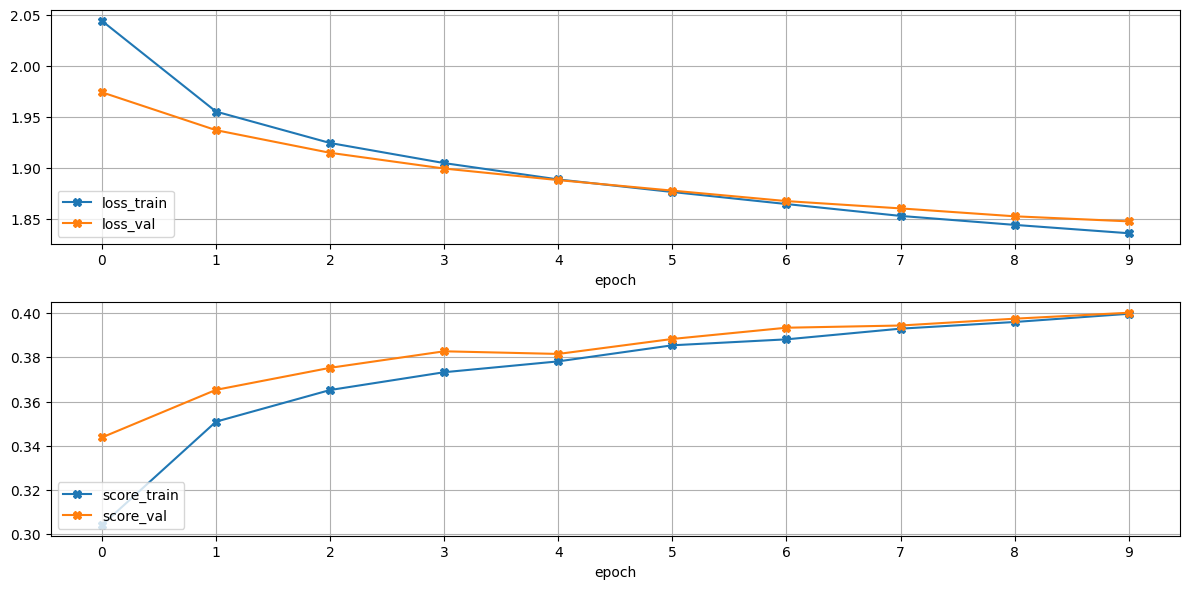

In [19]:
model = FCNet().to(device)  # Create model instance and move it to device

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weights update algorithm
criterion = nn.CrossEntropyLoss()  # Loss function

pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=10,
)

Выведите итоговую точность на валидационных данных.

In [20]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.40


Для следующего задания сохраним контрольную точку: обученную модель, состояние оптимизатора и прогресс обучения.

In [21]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "progress_plotter": pp,
    },
    f="checkpoint_task2.pth",
)

## Формат результата

График обучения сети.

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_2_task_ex05.png" width="800">

# Задание 3. Продолжение обучения из контольной точки

По результатам предыдущего задания видно, что если продолжить обучать модель еще несколько эпох, то качество может дополнительно улучшиться.

В этом задании вам необходимо:
1. Загрузить контрольную точку, содержащую обученную модель, состояние оптимизатора и прогресс обучения, из задания №2.
2. Продолжить обучение модели в течение еще 25 эпох.
3. Вывести суммарные графики обучения, содержащие информацию о предыдушем прогрессе и о результате дообучения.
4. Оценить качество модели на тестовых данных (обратите внимание, что в предыдущих заданиях мы не использовали тестовые данные).



Загрузим контрольную точку, которую мы сохранили в задании №2, и посмотрим, что в ней хранится:

In [22]:
checkpoint = torch.load("checkpoint_task2.pth")

print(f"Type of checkpoint: {type(checkpoint)}")
print(f"checkpoint keys: {checkpoint.keys()}")

Type of checkpoint: <class 'dict'>
checkpoint keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'progress_plotter'])


C:\Users\bleep\AppData\Local\Temp\ipykernel_18800\936520468.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_task2.pth")


Создайте новую модель класса `FCNet` и новый оптимизатор `torch.optim.SGD`.
Загрузите из контрольной точки состояние модели и состояние оптимизатора в созданные объекты с помощью метода `load_state_dict`.

In [23]:
model = FCNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Your code here
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Продолжите обучение модели еще в течение 25 эпох. Так как мы загрузили в модель состояние, в котором она уже была сколько-то обучена, то вызов кода обучения просто продолжит обучение.

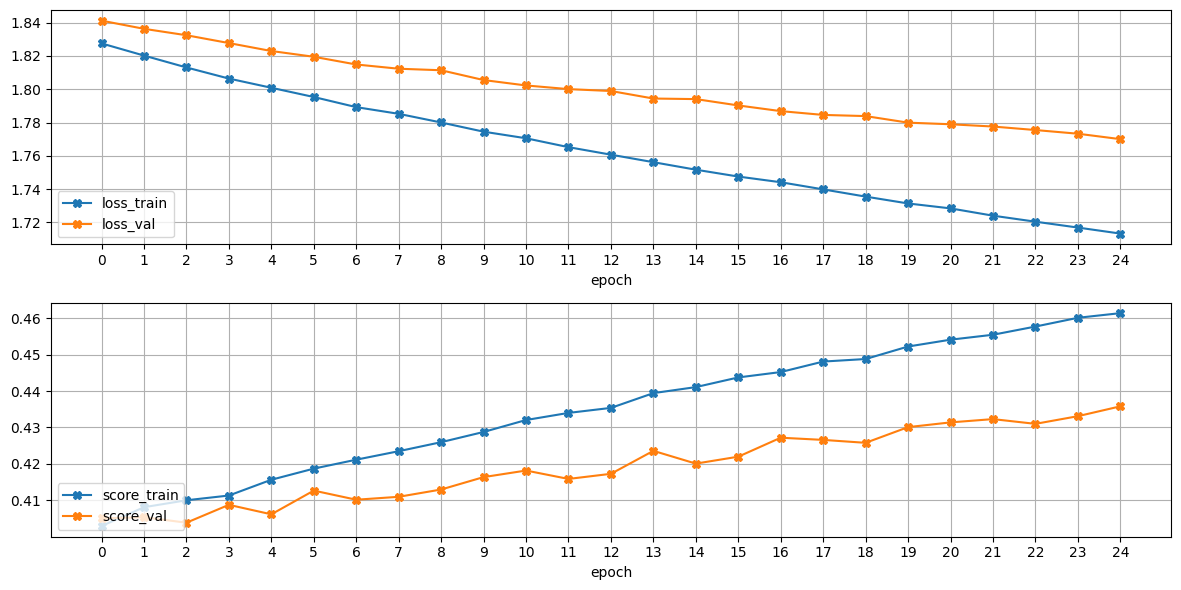

In [24]:
pp = train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    score_function,
    device,
    num_epochs=25,
)

Выведите итоговую точность на валидационных данных.

In [25]:
accuracy = pp.history_dict["score_val"][-1]
print(f"Accuracy {accuracy:.2f}")

Accuracy 0.44


Выше выведены графики только процесса дообучения.

Для построения суммарного графика процесса обучения загрузите из контрольной точки `progress_plotter`:

In [26]:
pp_old = checkpoint['progress_plotter']

print(f"pp_old.history_dict keys: {pp_old.history_dict.keys()}")
print(f'Type of pp_old.history_dict["loss_train"]: {type(pp_old.history_dict["loss_train"])}')

pp_old.history_dict keys: dict_keys(['loss_train', 'score_train', 'loss_val', 'score_val'])
Type of pp_old.history_dict["loss_train"]: <class 'list'>


Значениями (values) в словаре `pp_old.history_dict` являются списки.
По каждому ключу в словаре `pp_old.history_dict` добавьте в соответствующий список значения, полученные в результате дообучения.

In [27]:
for key in pp_old.history_dict.keys():
    pp_old.history_dict[key] += pp.history_dict[key]

Отобразим итоговые графики:

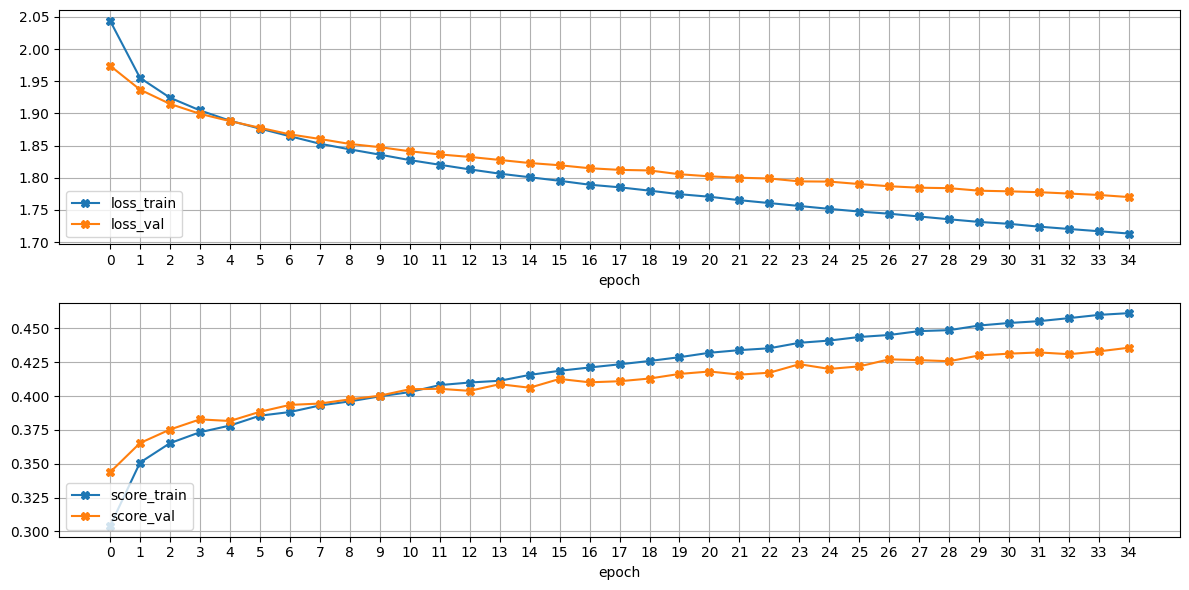

In [28]:
pp_old.display([["loss_train", "loss_val"], ["score_train", "score_val"]])

Оцените точность на **тестовом** датасете (`testset`).

1. Добавьте в тестовый Dataset трансформацию, включающую в себя нормализацию.
2. Cоздайте DataLoader для тестовых данных.
3. Оцените точность с помощью функции `val_loop`.



In [29]:
batch_size = 256

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_data.transform = transform_with_normalize
test_loss, test_score = val_loop(test_loader, model, criterion, score_function, device)

In [30]:
test_loss, test_score

(1.7752021849155426, 0.43070000410079956)

## Формат результата

1. Оценка точности на тестовых данных 0.48 .. 0.52
2. Суммарный график обучения. Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/result_3_task_ex05.png" width="800">

# Задание 4. Техники для работы в условиях дисбаланса классов

В этом задании вам предлагается решить задачу классификации на несбалансированном датасете [Car Evaluation](https://archive.ics.uci.edu/dataset/19/car+evaluation).

Требуется обучить полносвязную нейронную сеть, сделав бейзлайн с функцией потерь `CrossEntropyLoss`, а затем реализовать различные техники для работы в условиях дисбаланса:

1. `CrossEntropyLoss` **с весами для классов**,
2. `FocalLoss`,
3. `FocalLoss` **с весами для классов**,
4. `WeightedRandomSamlper` при функции потерь `CrossEntropyLoss`,
5. `WeightedRandomSamlper` при функции потерь `FocalLoss`,

сравнить их между собой и сделать выводы.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q torchmetrics

In [2]:
import torch
import torchmetrics
import pandas as pd

from torch import nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Обзор датасета и подготовка данных для обучния

Загрузим датасет и взглянем на него:

In [3]:
# !wget -qN https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/car_evaluation.zip
!unzip -qo car_evaluation.zip

"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [5]:
data = pd.read_csv(
    "car.data",
    names=["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"],
)

data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


В архиве найдем текстовый файл с описанием датасета `car.names`. Выведем его:

In [6]:
!cat car.names

1. Title: Car Evaluation Database

2. Sources:
   (a) Creator: Marko Bohanec
   (b) Donors: Marko Bohanec   (marko.bohanec@ijs.si)
               Blaz Zupan      (blaz.zupan@ijs.si)
   (c) Date: June, 1997

3. Past Usage:

   The hierarchical decision model, from which this dataset is
   derived, was first presented in 

   M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
   multi-attribute decision making. In 8th Intl Workshop on Expert
   Systems and their Applications, Avignon, France. pages 59-78, 1988.

   Within machine-learning, this dataset was used for the evaluation
   of HINT (Hierarchy INduction Tool), which was proved to be able to
   completely reconstruct the original hierarchical model. This,
   together with a comparison with C4.5, is presented in

   B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
   function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:

   Car Evaluation Database was 

Датасет содержит 1728 наблюдений об автомобилях, которые описываются шестью категориальными признаками:
1. `buying` — стоимость покупки
2. `maint` — стоимость обслуживания
3. `doors` — количество дверей
4. `persons` — количество пассажиров
5. `lug_boot` — размер багажника
6. `safety` — оценка безопасности машины.

Также имеется целевой признак `class` с четырьмя уникальными значениями:

* `unacc` — неприемлемо
* `acc` — приемлемо
* `good` — хорошо
* `vgood` — отлично

Оценим баланс классов:

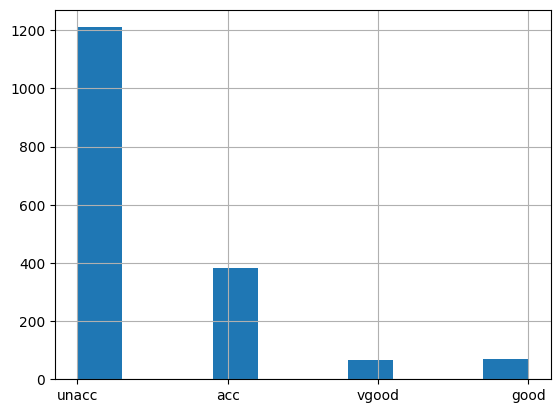

In [8]:
import matplotlib.pyplot as plt

data["class"].hist()
plt.show()

Посмотрим на описательные статистики по признакам:

In [9]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


Все входные признаки в датасете — категориальные, поэтому предварительно нужно их закодировать. Воспользуемся [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)-ом для кодирования входных признаков.

In [111]:
# split data to input x and target y
x, y = data.iloc[:, :-1], data.iloc[:, -1]

In [112]:
encoder = OneHotEncoder(sparse_output=False)

x_encoded = encoder.fit_transform(x)

x_encoded.shape

(1728, 21)

Классы просто закодируем порядковыми числами:

In [113]:
classes = ["unacc", "acc", "good", "vgood"]
class_labels = [0, 1, 2, 3]
class_to_idx = dict(zip(classes, class_labels))
class_to_idx

{'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

In [114]:
y_encoded = y.map(class_to_idx)  # mapping class names into their indexes
y_encoded = y_encoded.values  # transform Pandas Series into numpy array
y_encoded

array([0, 0, 0, ..., 0, 2, 3], dtype=int64)

Разделим данные на обучающие и тестовые в соотношении 80/20 и переведем их в `torch.tensor`:

In [115]:
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

Создадим `Dataset`-ы и `DataLoader`-ы для обучения нейросетей.

Обучающие и тестовые данные представляют из себя уже предобработанные тензоры. Поэтому для создания `Dataset`-ов можно воспользоваться классом [`TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset).

In [116]:
trainset = torch.utils.data.TensorDataset(x_train, y_train)

testset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Напишите архитектуру полносвязной сети для этого датасета. Рекомендуется использовать 1–2 скрытых слоя из 5–10 нейронов.

In [117]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 10)
        self.tan1 = nn.Tanh()
        self.fc2 = nn.Linear(10, 5)
        self.tan2 = nn.Tanh()
        self.fc3 = nn.Linear(5, 4)


    def forward(self, x):
        x = self.fc1(x)
        x = self.tan1(x)
        x = self.fc2(x)
        x = self.tan2(x)
        out = self.fc3(x)
        return out

## Показатель качества при дисбалансе

Так как набор данных несбалансирован, оценивать качество модели по accuracy будет некорректно. В качетсве функции оценки можем выбрать F1-score. Его реализацию для удобства возьмем из [`torchmetrics`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f-1-score):

In [118]:
score_function = torchmetrics.F1Score(task="multiclass", num_classes=4, average="macro")

## Бейзлайн c кросс-энтропией

Далее будет серия экспериментов по обучению нейросети на этом датасете с применением различных техник работы в условиях дисбаланса классов.
Для начала обучите бейзлайн с `CrossEntropyLoss`.

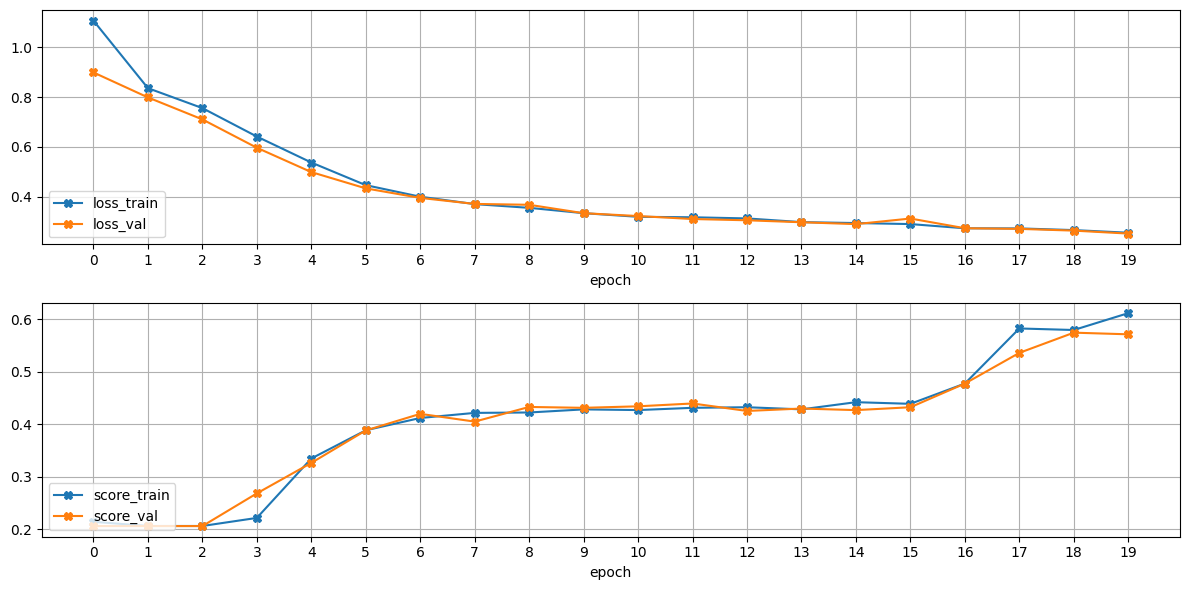

In [119]:
set_random_seed(42)

model = Network().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Напишем функцию для прогона DataLoader-a через модель и получения предсказаний.

In [120]:
def get_true_and_pred(dataloader, model):
    y_true, y_pred = [], []

    for input, target in dataloader:
        y_true.append(target)
        output = model(input.to(device))
        output = torch.argmax(output.cpu().detach(), dim=1)
        y_pred.append(output)

    y_true = np.array(torch.cat(y_true))
    y_pred = np.array(torch.cat(y_pred))

    return y_true, y_pred

Выведем отчет о качестве классификации тестовой выборки с помощью [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html):

In [123]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

              precision    recall  f1-score   support

       unacc       0.98      0.97      0.97       242
         acc       0.72      0.92      0.81        77
        good       0.00      0.00      0.00        14
       vgood       0.71      0.38      0.50        13

    accuracy                           0.90       346
   macro avg       0.60      0.57      0.57       346
weighted avg       0.87      0.90      0.88       346



Также посмотрим на матрицу ошибок ([`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Отобразим ее с помощью [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

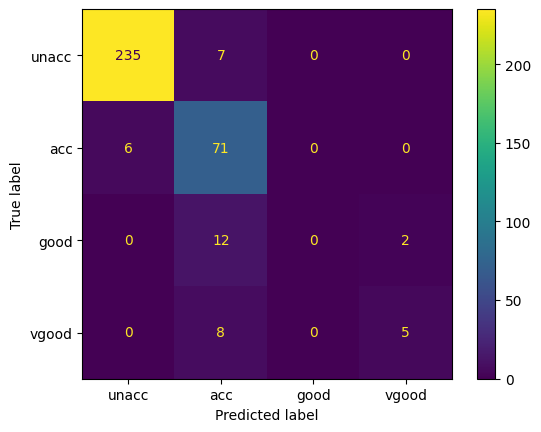

In [124]:
cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите результаты классификации. Какие проблемы вы наблюдаете?

В силу несбалансированности классов (т.е. у нас преобладают классы unacc и acc) нейронная сеть хорошо классифицирует эти классы, но при этом очень плохо классифицировала классы vgood, и особенно good (где у нас TP = 0)

## Кросс-энтропия с весами для классов

Вам нужно создать одномерный тензор `weights_for_classes` с весами для классов. В качестве весов можно взять величины, обратные к количеству объектов определенного класса в обучающей выборке.

**Обратите внимание**, тензор с весами `weights_for_classes` должен быть перенесен на `device`.

In [45]:
# Your code here

weights_for_classes = torch.tensor(1 / data["class"].value_counts()).float().to(device)

weights_for_classes

tensor([0.0008, 0.0026, 0.0145, 0.0154])

Обучите модель с `CrossEntropyLoss`, передав ей в качестве аргумента `weight` тензор `weights_for_classes`.

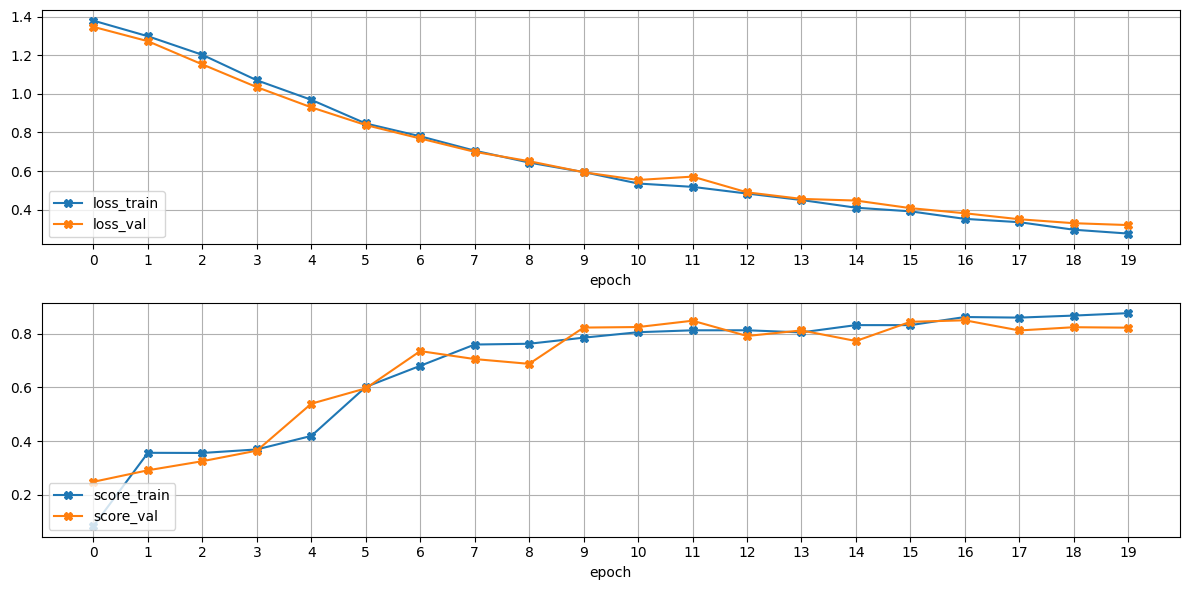

In [46]:
set_random_seed(42)

model = Network().to(device)

criterion =  nn.CrossEntropyLoss(weight = weights_for_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество обработки тестовой выборки с помощью отчета о классификации и матрицы ошибок.

              precision    recall  f1-score   support

       unacc       0.99      0.92      0.96       242
         acc       0.77      0.83      0.80        77
        good       0.67      0.86      0.75        14
       vgood       0.65      1.00      0.79        13

    accuracy                           0.90       346
   macro avg       0.77      0.90      0.82       346
weighted avg       0.92      0.90      0.91       346



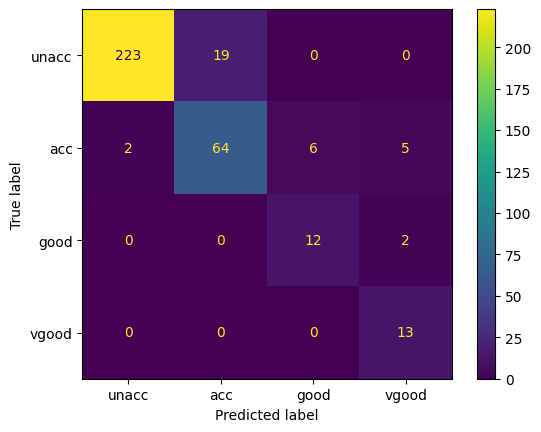

In [48]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Теперь, когда мы в качестве функции потерь взяли взвешенный logloss, то у нас качество модели заметно улучшилось для классов, количество которых заметно меньше.
Улучшилось оно за счет весов, которые мы присвоили каждому классу, где чем меньше объектова класса i в выборке, тем больше его все (в данном случае мы взяли вес 1 / количество объектов классa i)

## Focal Loss

Воспользуйтесь Focal Loss в качестве функции потерь подобно тому, как вы сделали в бейзлайне с кросс-энтропией.

В этом пункте **не используйте** веса для классов. Параметр $\gamma$ примите равным $2$.

In [49]:
#!wget -qN https://raw.githubusercontent.com/AdeelH/pytorch-multi-class-focal-loss/master/focal_loss.py
!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.1/Exercises/EX05/focal_loss.py

Информация из [документации](https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py):

* `alpha` (*Tensor*, optional): Weights for each class. Defaults to `None`.
* `gamma` (*float*, optional): A constant, as described in the paper. Defaults to `0`.
* `reduction` (*str*, optional): `'mean'`, `'sum'` or `'none'`. Defaults to `'mean'`.
* `ignore_index` (*int*, optional): class label to ignore. Defaults to `-100`.

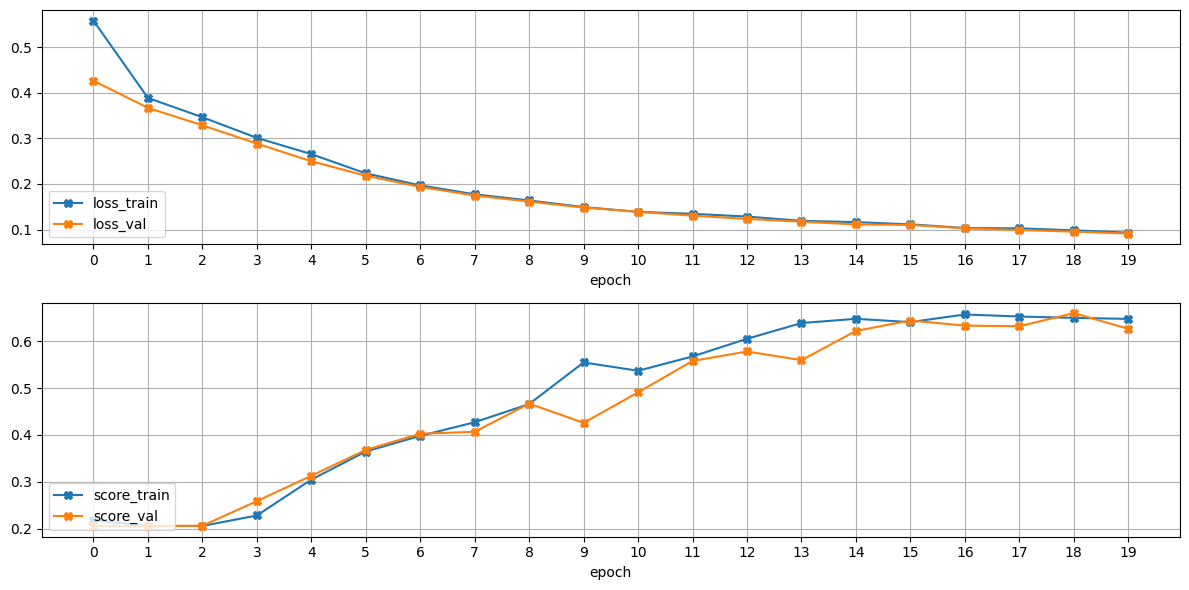

In [58]:
from focal_loss import FocalLoss

set_random_seed(42)

model = Network().to(device)

criterion = FocalLoss(gamma=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.97      0.98      0.97       242
         acc       0.76      0.88      0.81        77
        good       0.00      0.00      0.00        14
       vgood       0.75      0.69      0.72        13

    accuracy                           0.90       346
   macro avg       0.62      0.64      0.63       346
weighted avg       0.87      0.90      0.89       346



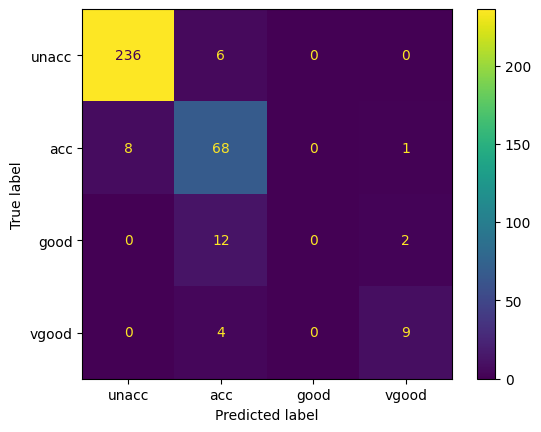

In [59]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Мы сравниваем две модели с невзвешенными logloss и focal loss (gamma = 2), т. е. 
LogLoss = sum(-log(p_i))
FocalLoss = sum(-alpha(1 - p_i)^2 * log(p_i))
Ну и по сравнению с невзвешенной logloss, focal loss имеет те же проблемы с несбалансированными классами good и vgood, но все-таки по macro avg она выигрывает
MacroAvg = среднее всех Precision и Recall

## Focal Loss с весами для классов

Обучите модель с Focal Loss, передав ей в качестве парамета `alpha` тензор весов `weights_for_classes`. Как и в прошлом пункте, используйте $\gamma=2$.

In [87]:
weights_for_classes *= 10

In [88]:
weights_for_classes

tensor([ 0.8264,  2.6042, 14.4928, 15.3846])

Пришлось умножать веса на 1000

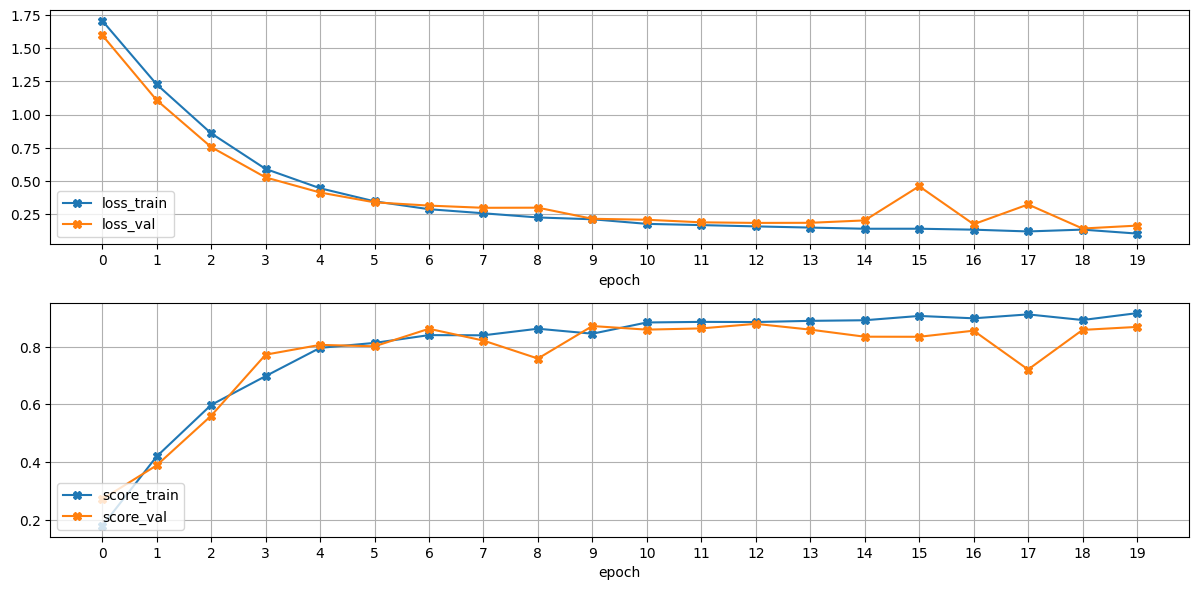

In [89]:
set_random_seed(42)

model = Network().to(device)

criterion = FocalLoss(alpha=weights_for_classes, gamma=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.99      0.95      0.97       242
         acc       0.85      0.88      0.87        77
        good       0.75      0.86      0.80        14
       vgood       0.72      1.00      0.84        13

    accuracy                           0.93       346
   macro avg       0.83      0.92      0.87       346
weighted avg       0.94      0.93      0.94       346



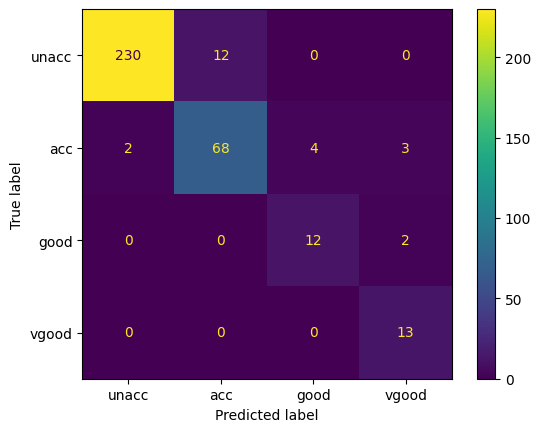

In [90]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Мне пришлось умножать веса на 1000, чтобы focal loss адекватно работал,

Как мы видим, качество модели стало лучшим, по сравнению с предыдущими моделями, как минимум, macro Precision, Recall и F1 заметно улучшились

Но судя по графику, есть маленький риск - что модель могла переобучиться

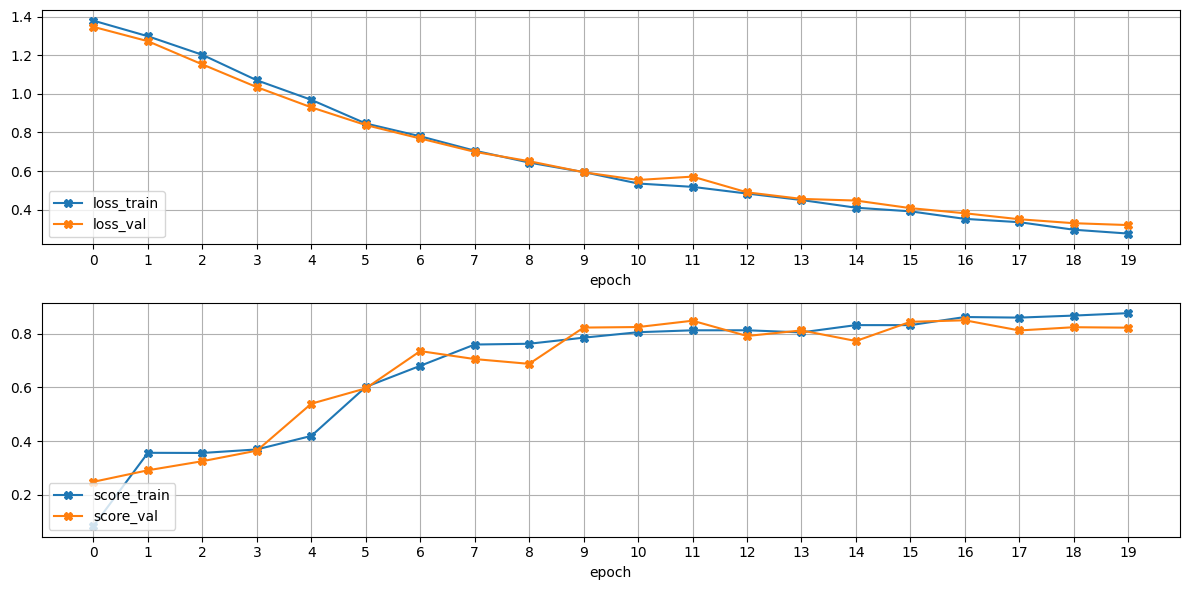

In [91]:
set_random_seed(42)

model = Network().to(device)

criterion =  nn.CrossEntropyLoss(weight = weights_for_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

## Weighted Random Sampler + Cross-Entropy Loss

Балансировать классы с помощью весов можно не только указывая их в функции потерь, но также и при формировании батчей.

Weighted Random Sampler занимается тем, что при формировании батчей учитывает веса разных объектов. Тем самым мы получаем возможность показывать модели объекты минорных классов чаще.

Особенность работы с Weighted Random Sampler в том, что ему нужно передать **веса для каждого объекта** в соответствии с тем, к какому классу этот объект относится. Создайте такой тензор весов `weight_for_every_sample`.

In [102]:
# Your code here

weights_for_classes = torch.tensor(1 / data["class"].value_counts()).float().to(device)

weight_for_every_sample = weights_for_classes[y_train]

weight_for_every_sample

tensor([0.0026, 0.0008, 0.0008,  ..., 0.0026, 0.0008, 0.0026])

Теперь нужно создать `sampler`.

`WeightedRandomSampler`-у при инициализации нужно передать массив весов для каждого объекта, а также параметр `num_samples` — количество объектов для выдачи за одну эпоху. Этот параметр можно принять равным длине обучающей выборки.

Далее нужно заново создать обучающий `DataLoader`, и передать ему взвешенный `sampler`.

In [103]:
sampler = WeightedRandomSampler(weight_for_every_sample, len(weight_for_every_sample), replacement=True)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, sampler=sampler)

Обучите модель с Cross-Entropy Loss **без весов для классов**, используя созданный выше `DataLoader` со взвешенным сэмплером. Обратите внимание, что мы уже учли дисбаланс во взвешенном сэмплере, поэтому указывать веса в функции потерь не нужно.

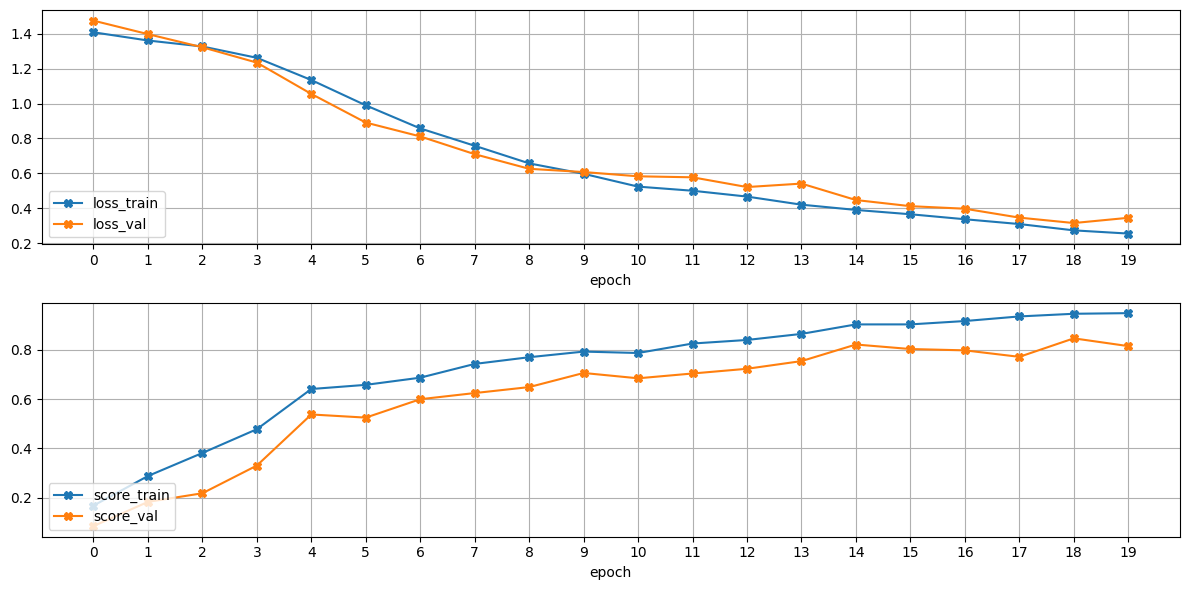

In [104]:
model = Network().to(device)

criterion =  nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       1.00      0.81      0.89       242
         acc       0.60      0.91      0.73        77
        good       0.75      0.86      0.80        14
       vgood       0.72      1.00      0.84        13

    accuracy                           0.84       346
   macro avg       0.77      0.89      0.81       346
weighted avg       0.89      0.84      0.85       346



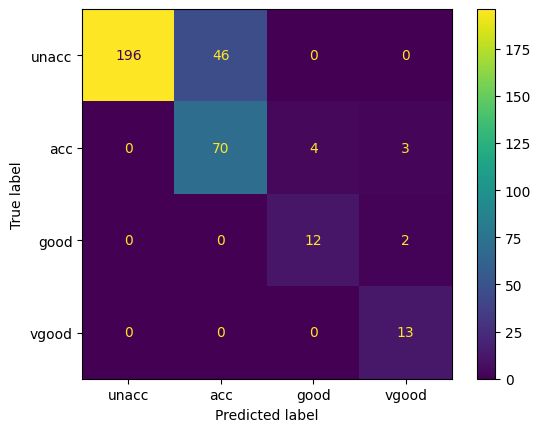

In [105]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Отличия от другие моделей в следующем:
1. В целом хорошие показатели метрики
2. Заметно, что для классов unacc и acc у нас модель довольно много ошибается и многие из acc он классифицировал как unacc

## Weighted Random Sampler + Focal Loss

Повторите обучение с Focal Loss, используя уже созданный `DataLoader` со взвешенным сэмплером.

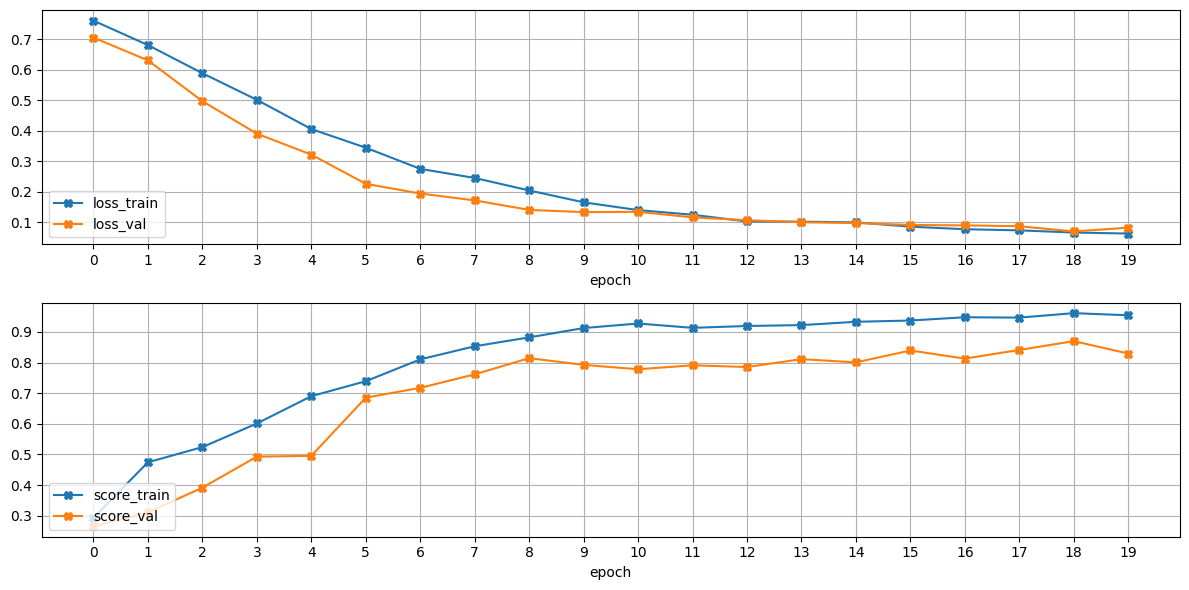

In [106]:
model = Network().to(device)

criterion = FocalLoss(gamma=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

pp = train(model, train_loader, test_loader, criterion, optimizer, score_function, device, num_epochs=20)

Оцените качество на тестовой выборке.

              precision    recall  f1-score   support

       unacc       0.99      0.92      0.95       242
         acc       0.76      0.84      0.80        77
        good       0.67      0.86      0.75        14
       vgood       0.68      1.00      0.81        13

    accuracy                           0.90       346
   macro avg       0.78      0.90      0.83       346
weighted avg       0.92      0.90      0.91       346



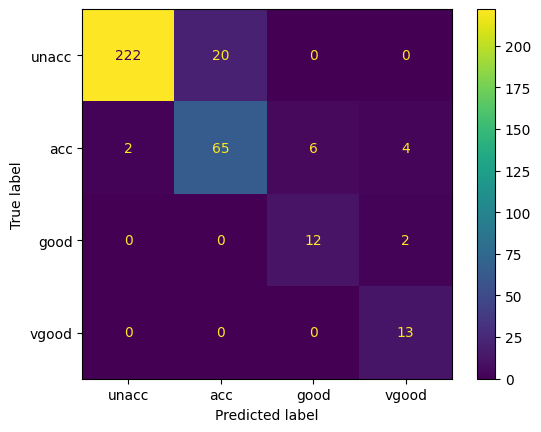

In [107]:
y_test_true, y_test_pred = get_true_and_pred(test_loader, model)

print(
    classification_report(
        y_test_true, y_test_pred, target_names=classes, zero_division=0
    )
)

cm = confusion_matrix(y_test_true, y_test_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=classes)
disp.plot()
plt.show()

Опишите, как изменилось качество классификации.

Здесь уже ошибок в классификации acc поменьше, чем в предыдущем примере с Weighted Random Sampler + кросс энтропии
И в целом, эта модель является хорошей, но не лучшей

## Сравнение результатов

Сравните результаты классификации тестовой выборки при обучении моделей с разными техниками борьбы с дисбалансом. В качестве меры сравнения можно выбрать *macro F-1 score*, который выводится в `classification_report`.

## Формат результата

Результатом выполнения задания является обучение модели с шестью техниками:
0. Бейзлайн с кросс-энтропией
1. Кросс-энтропия с весами для классов
2. Focal Loss
3. Focal Loss с весами для классов
4. Weighted Random Sampler + кросс-энтропия
5. Weighted Random Sampler + Focal Loss

Для каждого обучения требуется вывести отчет о качестве классификации тестовой выборки и матрицу ошибок.
В конце требуется сравнить качество классификации по метрике *macro F-1 score*.

macro avg       0.60      0.57      0.57
macro avg       0.77      0.90      0.82
macro avg       0.62      0.64      0.63
macro avg       0.83      0.92      0.87 
macro avg       0.77      0.89      0.81
macro avg       0.78      0.90      0.83

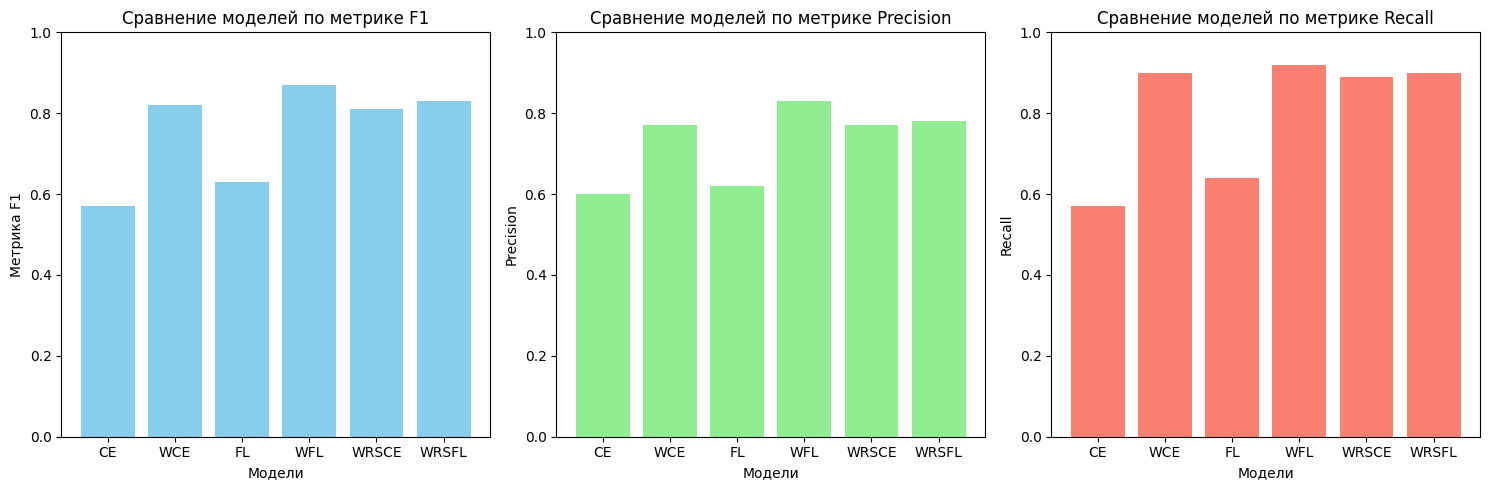

In [132]:
CE = [0.60, 0.57, 0.57]
WCE = [0.77, 0.90, 0.82]
FL = [0.62, 0.64, 0.63]
WFL = [0.83, 0.92, 0.87]
WRSCE = [0.77, 0.89, 0.81]
WRSFL = [0.78, 0.90, 0.83]

models = [CE, WCE, FL, WFL, WRSCE, WRSFL]

precision_macro_avg = [model[0] for model in models]
recall_macro_avg = [model[1] for model in models]
F1_macro_avg = [model[2] for model in models]

models = ['CE', 'WCE', 'FL', 'WFL', 'WRSCE', 'WRSFL']
plt.figure(figsize=(15,5))

# Создание графика для F1-Score
plt.subplot(1, 3, 1)
plt.bar(models, F1_macro_avg, color='skyblue')
plt.xlabel('Модели')
plt.ylabel('Метрика F1')
plt.title('Сравнение моделей по метрике F1')
plt.ylim(0, 1)

# Создание графика для Precision
plt.subplot(1, 3, 2)
plt.bar(models, precision_macro_avg, color='lightgreen')
plt.xlabel('Модели')
plt.ylabel('Precision')
plt.title('Сравнение моделей по метрике Precision')
plt.ylim(0, 1)

# Создание графика для Recall
plt.subplot(1, 3, 3)
plt.bar(models, recall_macro_avg, color='salmon')
plt.xlabel('Модели')
plt.ylabel('Recall')
plt.title('Сравнение моделей по метрике Recall')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()